In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 21.8 MB/s eta 0:00:00


In [3]:
import koreanize_matplotlib

In [4]:
# 딕셔너리를 만들 때 필요한 리스트 변수를 만들고 반환하는 함수
def make_var_name_lst():
  var_name_lst = []
  # 각 기업 별로 나누기 위한 변수 만들기
  for i in range(1,5):
    tmp_lst = []
    date_name = '기간'
    profit_name = f'영업이익{i}'
    debt_name = f'부채{i}'
    market_name = f'시가총액{i}'
    tmp_lst.append(date_name)
    tmp_lst.append(profit_name)
    tmp_lst.append(debt_name)
    tmp_lst.append(market_name)
    var_name_lst.append(tmp_lst)
  return var_name_lst

In [5]:
# 각 기업 별 데이터프레임을 만들기 위한 딕셔너리를 만들고 반환하는 함수
def make_dict(country_df, company_lst):

  var_name_lst = make_var_name_lst()

  # 각 기업 별로 데이터프레임 만들기 위한 딕셔너리 만들기
  data_dict = {}
  for company, var in zip(company_lst, var_name_lst):
    data_dict[company] = country_df[var]
  return data_dict

In [49]:
# 각 기업 별 데이터프레임 만들기 위한 함수
def process_company_data(data_dict, company_key, var_name_lst_no_date, index):
  company = data_dict[company_key]
  company.index = company['기간']
  company = company.replace(0, np.nan)
  company = company.dropna()

  selected_vars = var_name_lst_no_date[index]
  company = company[selected_vars]
  company_profit_series = company[selected_vars[0]]
  company_debt_series = company[selected_vars[1]]
  company_market_series = company[selected_vars[2]]
  df_ = {
      '영업이익':company_profit_series,
      '부채':company_debt_series,
      '시가총액':company_market_series,
  }
  company_df = pd.DataFrame(df_, index=company.index)

  return company_df

In [50]:
# 해당 산업 내 기업들의 credit risk를 계산해 하나의 데이터프레임으로 만드는 함수
def cal_credit_risk(r, data_dict, company_lst, var_name_lst_no_date):
  series_container = []
  for i in range(len(company_lst)):
    company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
    company_i_profit_series = company_i['영업이익']
    company_i_debt_series = company_i['부채']
    company_i_market_series = company_i['시가총액']

    # recovery rate 계산
    recovery_rate_series_i = company_i_profit_series / company_i_debt_series
    recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
    # 부도확률 계산
    STD_V = company_i_market_series.std()
    R = r
    T = company_i_market_series.shape[0]
    tmp = []
    for V, K in zip(company_i_market_series, company_i_debt_series):
      d1 = ((np.log(V)-np.log(K)) + (R + 0.5 * STD_V**2) * T) / (STD_V * np.sqrt(T))
      d2 = d1 - STD_V * np.sqrt(T)
      # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
      def_prob = norm.logcdf(d2)
      tmp.append(def_prob)
    company_i_default_rate_series = pd.Series(tmp, index=company_i.index)
    company_i_default_rate_series = (company_i_default_rate_series/company_i_default_rate_series.iloc[0])
    company_i_default_rate_series = company_i_default_rate_series.clip(upper=1, lower=0)
    # EAD 계산
    company_i_ead_series = company_i_debt_series / company_i_debt_series.iloc[0]
    # credit risk 계산
    company_i_cr = company_i_default_rate_series * recovery_rate_series_i * company_i_ead_series
    # 데이터프레임 생성을 위한 리스트에 cr 시리즈를 붙인다.
    series_container.append(company_i_cr)

  # 데이터프레임 생성
  df = pd.DataFrame({'company1':series_container[0],'company2':series_container[1],'company3':series_container[2],'company4':series_container[3]})
  # 데이터프레임 반환
  return df

In [51]:
# 기본 변수들
manu_india = pd.read_excel("/content/미국_소매.xlsx") # make_dict의 매개변수로 쓰일 변수. 바꿔줘야 한다.
gdp_india = manu_india['gdp성장률']
gdp_india.index = manu_india['기간']
company_lst = ['company1', 'company2', 'company3', 'company4']
var_name_lst_no_date = [
    ['영업이익1', '부채1', '시가총액1'],
    ['영업이익2', '부채2', '시가총액2'],
    ['영업이익3', '부채3', '시가총액3'],
    ['영업이익4', '부채4', '시가총액4']
]
# gdp_india
manu_india

,기간,영업이익1,부채1,시가총액1,영업이익2,부채2,시가총액2,영업이익3,부채3,시가총액3,영업이익4,부채4,시가총액4,실업률,gdp성장률
0,2013-03-01,-0.984007,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,1812.461490,0.000000,0.000000,58.708146,7.682498,1.6
1,2013-06-01,-8.714422,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,1562.744574,0.000000,0.000000,68.428038,7.412812,1.3
2,2013-09-01,-1.889657,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,2215.230710,0.000000,0.000000,68.428038,7.119918,1.9
3,2013-12-01,-5.554220,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,1107.615355,0.000000,0.000000,68.428038,6.721312,2.5
4,2014-03-01,-5.748278,7.256745,7497.696799,0.000000,0.000000,0.000000,-2.924046,231.486445,1308.999965,0.000000,0.000000,88.256617,6.304996,1.3
5,2014-06-01,-11.016639,17.403856,7497.696799,0.000000,0.000000,0.000000,-11.364695,282.256362,1445.941500,0.000000,0.000000,68.428038,6.172873,2.5
6,2014-09-01,-28.697663,34.165786,7497.696799,0.000000,0.000000,0.000000,6.581411,225.986545,2416.615320,0.000000,0.000000,39.268363,5.830863,2.8
7,2014-12-01,-5.343051,41.417642,7497.696799,0.000000,0.000000,0.000000,-18.951297,251.494538,2517.307625,0.000000,0.000000,48.988255,5.600676,2.6
8,2015-03-01,-6.058581,52.256926,7497.696799,0.000000,0.000000,0.000000,3.754598,208.394199,1812.461490,0.000000,0.000000,48.988255,5.519415,3.8
9,2015-06-01,-5.975879,61.640299,7497.696799,0.000000,0.000000,0.000000,-10.743274,296.516720,9042.168989,0.000000,0.000000,68.428038,5.197796,3.0


In [52]:
R = 0.041
data_dict = make_dict(manu_india, company_lst)
cr_df = cal_credit_risk(R, data_dict, company_lst, var_name_lst_no_date)
# cr_df.shape
# cr_df.plot()
# 각자의 시작 시점이 기준.
# cr_df # 음수가 나오면 안 되는데 음수가 나온다.
cr_df['gdp'] = gdp_india
cr_df

,company1,company2,company3,company4,gdp
기간,,,,,
2014-03-01,0.000000,NaN,0.000000,NaN,1.3
2014-06-01,0.000000,NaN,0.000000,NaN,2.5
2014-09-01,0.000000,NaN,0.028431,NaN,2.8
2014-12-01,0.000000,NaN,0.000000,NaN,2.6
2015-03-01,0.000000,NaN,0.016220,NaN,3.8
2015-06-01,0.000000,NaN,0.000000,NaN,3.0
2015-09-01,0.000000,NaN,0.012617,NaN,2.2
2015-12-01,10.107678,NaN,0.000000,NaN,1.9
2016-03-01,0.000000,NaN,0.000000,NaN,1.6


In [44]:
data_dict['company1']

,기간,영업이익1,부채1,시가총액1
기간,,,,
2013-03-01,2013-03-01,-0.984007,0.000000,7497.696799
2013-06-01,2013-06-01,-8.714422,0.000000,7497.696799
2013-09-01,2013-09-01,-1.889657,0.000000,7497.696799
2013-12-01,2013-12-01,-5.554220,0.000000,7497.696799
2014-03-01,2014-03-01,-5.748278,7.256745,7497.696799
2014-06-01,2014-06-01,-11.016639,17.403856,7497.696799
2014-09-01,2014-09-01,-28.697663,34.165786,7497.696799
2014-12-01,2014-12-01,-5.343051,41.417642,7497.696799
2015-03-01,2015-03-01,-6.058581,52.256926,7497.696799


In [36]:
company_i = data_dict['company1']
company_i

,기간,영업이익1,부채1,시가총액1
기간,,,,
2013-03-01,2013-03-01,-0.984007,0.000000,7497.696799
2013-06-01,2013-06-01,-8.714422,0.000000,7497.696799
2013-09-01,2013-09-01,-1.889657,0.000000,7497.696799
2013-12-01,2013-12-01,-5.554220,0.000000,7497.696799
2014-03-01,2014-03-01,-5.748278,7.256745,7497.696799
2014-06-01,2014-06-01,-11.016639,17.403856,7497.696799
2014-09-01,2014-09-01,-28.697663,34.165786,7497.696799
2014-12-01,2014-12-01,-5.343051,41.417642,7497.696799
2015-03-01,2015-03-01,-6.058581,52.256926,7497.696799


In [48]:
data = {
    'A': [np.nan, 2, 3, 4, 5, 6],
    'B': [1, 2, 3, 4, 0, 6],
    'C': [1, 2, 3, 4, 5, 6],
    'D': [1, 2, 3, 4, 5, 6],
    'E': [1, 2, 3, 4, 5, 6],
    'F': [0, 2, 3, 4, 5, 6]
}
df = pd.DataFrame(data)
df.replace(0, np.nan)

,A,B,C,D,E,F
0,NaN,1.0,1,1,1,NaN
1,2.0,2.0,2,2,2,2.0
2,3.0,3.0,3,3,3,3.0
3,4.0,4.0,4,4,4,4.0
4,5.0,NaN,5,5,5,5.0
5,6.0,6.0,6,6,6,6.0


In [29]:
profit = []
debt = []
for i in range(len(company_lst)):
  company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
  company_i_profit_series = company_i['영업이익']
  company_i_debt_series = company_i['부채']
  # company_i_market_series = company_i['시가총액']
  profit.append(company_i_profit_series)
  debt.append(company_i_debt_series)

company_i_profit_series = pd.Series(profit)
company_i_debt_series = pd.Series(profit)
recovery_rate_series_i = company_i_profit_series / company_i_debt_series
# recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
profit
# recovery_rate_series_i

[기간
 2013-03-01      -0.984007
 2013-06-01      -8.714422
 2013-09-01      -1.889657
 2013-12-01      -5.554220
 2014-03-01      -5.748278
 2014-06-01     -11.016639
 2014-09-01     -28.697663
 2014-12-01      -5.343051
 2015-03-01      -6.058581
 2015-06-01      -5.975879
 2015-09-01     -36.644815
 2015-12-01     295.470109
 2016-03-01     -57.837899
 2016-06-01    -143.082139
 2016-09-01    -188.503708
 2016-12-01    -120.092014
 2017-03-01     -71.332209
 2017-06-01     -57.837899
 2017-09-01    -206.225201
 2017-12-01    -103.413058
 2018-03-01    -107.945519
 2018-06-01    -152.545091
 2018-09-01    -412.287849
 2018-12-01    -281.693878
 2019-03-01    -198.325851
 2019-06-01     -88.775448
 2019-09-01    -342.542735
 2019-12-01     -55.865540
 2020-03-01     -24.417519
 2020-06-01    -116.725804
 2020-09-01    -149.909484
 2020-12-01    -125.914846
 2021-03-01      46.955430
 2021-06-01    -205.275687
 2021-09-01    -779.425186
 2021-12-01     -10.569721
 2022-03-01    -112.9991

In [53]:
cr_df.corr()

,company1,company2,company3,company4,gdp
company1,1.000000,-0.076781,-0.060737,-0.063729,-0.045407
company2,-0.076781,1.000000,-0.111867,-0.102216,-0.025982
company3,-0.060737,-0.111867,1.000000,-0.063729,0.177916
company4,-0.063729,-0.102216,-0.063729,1.000000,-0.323547
gdp,-0.045407,-0.025982,0.177916,-0.323547,1.000000


<Axes: >

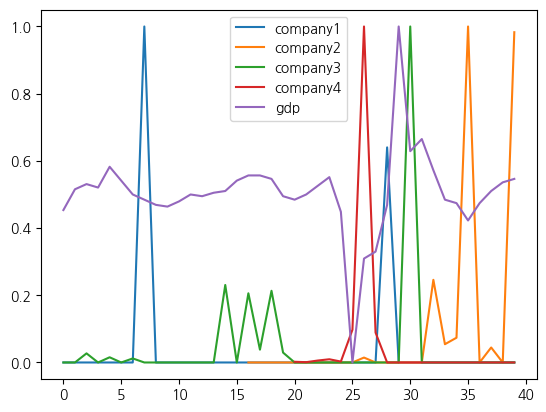

In [54]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(cr_df)
normalized_df = pd.DataFrame(normalized_data, columns=cr_df.columns)
normalized_df.plot()

<Axes: >

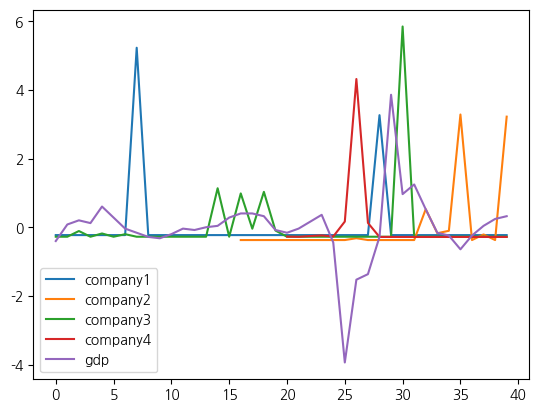

In [55]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(cr_df)
normalized_df = pd.DataFrame(normalized_data, columns=cr_df.columns)
normalized_df.plot()

In [56]:
normalized_df.corr()

,company1,company2,company3,company4,gdp
company1,1.000000,-0.076781,-0.060737,-0.063729,-0.045407
company2,-0.076781,1.000000,-0.111867,-0.102216,-0.025982
company3,-0.060737,-0.111867,1.000000,-0.063729,0.177916
company4,-0.063729,-0.102216,-0.063729,1.000000,-0.323547
gdp,-0.045407,-0.025982,0.177916,-0.323547,1.000000


# 노트

In [45]:
################## 실험용 ###################
r = 0.041
series_container = {}
for i in range(len(company_lst)-3):
  company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
  company_i_profit_series = company_i['영업이익']
  company_i_debt_series = company_i['부채']
  company_i_market_series = company_i['시가총액']

  # recovery rate 계산
  recovery_rate_series_i = company_i_profit_series / company_i_debt_series
  recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
  # 부도확률 계산
  STD_V = company_i_market_series.std()
  R = r
  T = company_i_market_series.shape[0]
  tmp = []
  for V, K in zip(company_i_market_series, company_i_debt_series):
    d1 = ((np.log(V)-np.log(K)) + (R + 0.5 * STD_V**2) * T) / (STD_V * np.sqrt(T))
    d2 = d1 - STD_V * np.sqrt(T)
    # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
    def_prob = norm.logcdf(d2)
    tmp.append(def_prob)
  # print(tmp) # 값은 계산이 됨
  company_i_default_rate_series = pd.Series(tmp, index=company_i.index)
  company_i_default_rate_series = (company_i_default_rate_series/company_i_default_rate_series.iloc[0])
  # print(company_i_default_rate_series)
  company_i_default_rate_series = company_i_default_rate_series.clip(upper=1, lower=0)
  # EAD 계산
  company_i_ead_series = company_i_debt_series / company_i_debt_series.iloc[0]
  print(company_i_ead_series)
  # credit risk 계산
  company_i_cr = company_i_default_rate_series * recovery_rate_series_i * company_i_ead_series
  # 데이터프레임 생성을 위한 리스트에 cr 시리즈를 붙인다.
  series_container[company_lst[i]] = company_i_cr

# 데이터프레임 생성
# df = pd.DataFrame({'company1':series_container[0],'company2':series_container[1],'company3':series_container[2],'company4':series_container[3]})
# df

기간
2013-03-01    NaN
2013-06-01    NaN
2013-09-01    NaN
2013-12-01    NaN
2014-03-01    inf
2014-06-01    inf
2014-09-01    inf
2014-12-01    inf
2015-03-01    inf
2015-06-01    inf
2015-09-01    inf
2015-12-01    inf
2016-03-01    inf
2016-06-01    inf
2016-09-01    inf
2016-12-01    inf
2017-03-01    inf
2017-06-01    inf
2017-09-01    inf
2017-12-01    inf
2018-03-01    inf
2018-06-01    inf
2018-09-01    inf
2018-12-01    inf
2019-03-01    inf
2019-06-01    inf
2019-09-01    inf
2019-12-01    inf
2020-03-01    inf
2020-06-01    inf
2020-09-01    inf
2020-12-01    inf
2021-03-01    inf
2021-06-01    inf
2021-09-01    inf
2021-12-01    inf
2022-03-01    inf
2022-06-01    inf
2022-09-01    inf
2022-12-01    inf
2023-03-01    inf
2023-06-01    inf
2023-09-01    inf
2023-12-01    inf
Name: 부채, dtype: float64


In [ ]:
company2 = data_dict['company3']
company2 = company2[var_name_lst_no_date[2]]
company2

,영업이익3,부채3,시가총액3
기간,,,
2013-03-01,NaN,NaN,24.222986
2013-06-01,NaN,NaN,26.843415
2013-09-01,NaN,NaN,23.775596
2013-12-01,NaN,NaN,16.617352
2014-03-01,NaN,NaN,20.222039
2014-06-01,NaN,NaN,21.091255
2014-09-01,NaN,NaN,35.024265
2014-12-01,NaN,NaN,26.843415
2015-03-01,NaN,NaN,21.091255


In [ ]:
# company1
# company1.plot()
company2_profit_series = company2['영업이익3']
company2_debt_series = company2['부채3']
company2_market_series = company2['시가총액3']

In [ ]:
# Recovery Rate 계산
# company1_profit_norm = (company1_profit_series / company1_profit_series[0])
recovery_rate_series = company2_profit_series / company2_debt_series
# recovery_rate의 값이 음수면 영업이익이 적자이므로 사실상 0. 1보다 크면 그냥 1임. 그러므로 LGD는 0이 됨.
recovery_rate_series = recovery_rate_series.clip(upper=1, lower=0)
recovery_rate_series

기간
2013-03-01         NaN
2013-06-01         NaN
2013-09-01         NaN
2013-12-01         NaN
2014-03-01         NaN
2014-06-01         NaN
2014-09-01         NaN
2014-12-01         NaN
2015-03-01         NaN
2015-06-01         NaN
2015-09-01         NaN
2015-12-01         NaN
2016-03-01         NaN
2016-06-01         NaN
2016-09-01         NaN
2016-12-01         NaN
2017-03-01    0.000000
2017-06-01    0.000000
2017-09-01    0.000000
2017-12-01    0.000000
2018-03-01    1.000000
2018-06-01    0.000000
2018-09-01    0.000000
2018-12-01    0.000000
2019-03-01    0.000000
2019-06-01    0.000000
2019-09-01    0.000000
2019-12-01    0.014878
2020-03-01    0.000000
2020-06-01    0.000000
2020-09-01    0.000000
2020-12-01    0.000000
2021-03-01    0.000000
2021-06-01    0.000000
2021-09-01    0.000000
2021-12-01    0.000000
2022-03-01    0.000000
2022-06-01    1.000000
2022-09-01    0.000000
2022-12-01    0.190250
2023-03-01    0.000000
2023-06-01    0.009708
2023-09-01    0.000000
2023-12-

In [ ]:
# 개별 기업에 대해서 실험
# 부도확률 계산
STD_V = company2_market_series.std()
R = 0.041
T = company2_market_series.shape[0]
tmp = []
for V, K in zip(company2_market_series, company2_debt_series):
  d1 = (np.log(V) - np.log(K)) + ((R+(0.5*(STD_V**2)))*T) / (STD_V*np.sqrt(T))
  d2 = d1 - (STD_V*np.sqrt(T))
  # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
  def_prob = norm.logcdf(d2)
  tmp.append(def_prob)
#default_dict = {'부도율':tmp}
company2_default_rate_series = pd.Series(tmp, index=company2.index)
# mt_df_company1 = pd.DataFrame(def_dict, index=company1.index)
# 부도확률
company2_default_rate_series = 1-(company2_default_rate_series/company2_default_rate_series.iloc[0]) ############### 다른 점
company2_default_rate_series = company2_default_rate_series.clip(upper=1, lower=0)
company2_default_rate_series
# default_rate_df_company1.plot()
# company2_default_rate_series.plot()

기간
2013-03-01   NaN
2013-06-01   NaN
2013-09-01   NaN
2013-12-01   NaN
2014-03-01   NaN
2014-06-01   NaN
2014-09-01   NaN
2014-12-01   NaN
2015-03-01   NaN
2015-06-01   NaN
2015-09-01   NaN
2015-12-01   NaN
2016-03-01   NaN
2016-06-01   NaN
2016-09-01   NaN
2016-12-01   NaN
2017-03-01   NaN
2017-06-01   NaN
2017-09-01   NaN
2017-12-01   NaN
2018-03-01   NaN
2018-06-01   NaN
2018-09-01   NaN
2018-12-01   NaN
2019-03-01   NaN
2019-06-01   NaN
2019-09-01   NaN
2019-12-01   NaN
2020-03-01   NaN
2020-06-01   NaN
2020-09-01   NaN
2020-12-01   NaN
2021-03-01   NaN
2021-06-01   NaN
2021-09-01   NaN
2021-12-01   NaN
2022-03-01   NaN
2022-06-01   NaN
2022-09-01   NaN
2022-12-01   NaN
2023-03-01   NaN
2023-06-01   NaN
2023-09-01   NaN
2023-12-01   NaN
dtype: float64

In [ ]:
# 개별 기업에 대해서 실험
# 부도확률 계산
STD_V = company2_market_series.std()
R = 0.041
T = company2_market_series.shape[0]
tmp = []
for V, K in zip(company2_market_series, company2_debt_series):
  d1 = (np.log(V) - np.log(K)) + ((R+(0.5*(STD_V**2)))*T) / (STD_V*np.sqrt(T))
  d2 = d1 - (STD_V*np.sqrt(T))
  # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
  def_prob = norm.logcdf(d2)
  tmp.append(def_prob)
#default_dict = {'부도율':tmp}
company2_default_rate_series = pd.Series(tmp, index=company2.index)
# mt_df_company1 = pd.DataFrame(def_dict, index=company1.index)
# 부도확률
company2_default_rate_series = (company2_default_rate_series/company2_default_rate_series.iloc[0])
company2_default_rate_series = company2_default_rate_series.clip(upper=1, lower=0)
company2_default_rate_series

기간
2013-03-01   NaN
2013-06-01   NaN
2013-09-01   NaN
2013-12-01   NaN
2014-03-01   NaN
2014-06-01   NaN
2014-09-01   NaN
2014-12-01   NaN
2015-03-01   NaN
2015-06-01   NaN
2015-09-01   NaN
2015-12-01   NaN
2016-03-01   NaN
2016-06-01   NaN
2016-09-01   NaN
2016-12-01   NaN
2017-03-01   NaN
2017-06-01   NaN
2017-09-01   NaN
2017-12-01   NaN
2018-03-01   NaN
2018-06-01   NaN
2018-09-01   NaN
2018-12-01   NaN
2019-03-01   NaN
2019-06-01   NaN
2019-09-01   NaN
2019-12-01   NaN
2020-03-01   NaN
2020-06-01   NaN
2020-09-01   NaN
2020-12-01   NaN
2021-03-01   NaN
2021-06-01   NaN
2021-09-01   NaN
2021-12-01   NaN
2022-03-01   NaN
2022-06-01   NaN
2022-09-01   NaN
2022-12-01   NaN
2023-03-01   NaN
2023-06-01   NaN
2023-09-01   NaN
2023-12-01   NaN
dtype: float64

In [ ]:
# 해당 산업 내 기업들의 credit risk를 계산해 하나의 데이터프레임으로 만드는 함수. 값들은 전부 정규화된다.
def cal_credit_risk_norm(r, data_dict, company_lst, var_name_lst_no_date):
  series_container = []
  for i in range(len(company_lst)):
    company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
    company_i_profit_series = company_i['영업이익']
    company_i_debt_series = company_i['부채']
    company_i_market_series = company_i['시가총액']

    # 정규화를 위한 scaler
    scaler = MinMaxScaler()

    # recovery rate 계산
    recovery_rate_series_i = company_i_profit_series / company_i_debt_series
    recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
    # 부도확률 계산
    STD_V = company_i_market_series.std()
    R = r
    T = company_i_market_series.shape[0]
    tmp = []
    for V, K in zip(company_i_market_series, company_i_debt_series):
      d1 = (np.log(V/K) + (R + 0.5 * STD_V**2) * T) / (STD_V * np.sqrt(T))
      d2 = d1 - STD_V * np.sqrt(T)
      # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
      def_prob = norm.logcdf(d2)
      tmp.append(def_prob)
    company_i_default_rate_series = pd.Series(tmp, index=company_i.index)
    company_i_default_rate_series = (company_i_default_rate_series/company_i_default_rate_series.iloc[0])
    company_i_default_rate_series = company_i_default_rate_series.clip(upper=1, lower=0)
    # EAD 계산
    company_i_ead_series = company_i_debt_series / company_i_debt_series.iloc[0]
    # credit risk 계산
    company_i_cr = company_i_default_rate_series * recovery_rate_series_i * company_i_ead_series
    # 데이터프레임 생성을 위한 리스트에 cr 시리즈를 붙인다.
    series_container.append(company_i_cr)

  # 데이터프레임 생성
  df = pd.DataFrame({'company1':series_container[0],'company2':series_container[1],'company3':series_container[2],'company4':series_container[3]})
  # 데이터프레임 반환
  return df

In [ ]:
# 개별 기업에 대해서 실험
# 부도확률 계산
STD_V = company2_market_series.std()
R = 0.041
T = company2_market_series.shape[0]
tmp = []
for V, K in zip(company2_market_series, company2_debt_series):
  d1 = (np.log(V) - np.log(K)) + ((R+(0.5*(STD_V**2)))*T) / (STD_V*np.sqrt(T))
  d2 = d1 - (STD_V*np.sqrt(T))
  # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
  def_prob = norm.logcdf(d2)
  tmp.append(def_prob)
#default_dict = {'부도율':tmp}
company2_default_rate_series = pd.Series(tmp, index=company2.index)
# mt_df_company1 = pd.DataFrame(def_dict, index=company1.index)
# 부도확률
company2_default_rate_series = (company2_default_rate_series/company2_default_rate_series.iloc[0])
company2_default_rate_series = company2_default_rate_series.clip(upper=1, lower=0)
company2_default_rate_series

기간
2013-03-01   NaN
2013-06-01   NaN
2013-09-01   NaN
2013-12-01   NaN
2014-03-01   NaN
2014-06-01   NaN
2014-09-01   NaN
2014-12-01   NaN
2015-03-01   NaN
2015-06-01   NaN
2015-09-01   NaN
2015-12-01   NaN
2016-03-01   NaN
2016-06-01   NaN
2016-09-01   NaN
2016-12-01   NaN
2017-03-01   NaN
2017-06-01   NaN
2017-09-01   NaN
2017-12-01   NaN
2018-03-01   NaN
2018-06-01   NaN
2018-09-01   NaN
2018-12-01   NaN
2019-03-01   NaN
2019-06-01   NaN
2019-09-01   NaN
2019-12-01   NaN
2020-03-01   NaN
2020-06-01   NaN
2020-09-01   NaN
2020-12-01   NaN
2021-03-01   NaN
2021-06-01   NaN
2021-09-01   NaN
2021-12-01   NaN
2022-03-01   NaN
2022-06-01   NaN
2022-09-01   NaN
2022-12-01   NaN
2023-03-01   NaN
2023-06-01   NaN
2023-09-01   NaN
2023-12-01   NaN
dtype: float64

In [ ]:
company1 = data_dict['company1'][['영업이익1', '부채1', '시가총액1']]
selected_vars = var_name_lst_no_date[0]
company1[selected_vars[0]]

기간
2013-03-01       NaN
2013-06-01       NaN
2013-09-01       NaN
2013-12-01       NaN
2014-03-01       NaN
2014-06-01       NaN
2014-09-01     0.129
2014-12-01     0.133
2015-03-01     0.497
2015-06-01     0.928
2015-09-01     0.605
2015-12-01     0.825
2016-03-01     0.099
2016-06-01     0.109
2016-09-01     0.287
2016-12-01     0.323
2017-03-01     0.174
2017-06-01     0.121
2017-09-01     0.108
2017-12-01     0.099
2018-03-01    -0.353
2018-06-01     0.068
2018-09-01    -0.389
2018-12-01    -1.924
2019-03-01    -2.759
2019-06-01    -0.181
2019-09-01    -1.657
2019-12-01    -0.520
2020-03-01    -0.404
2020-06-01    -0.263
2020-09-01    -0.328
2020-12-01   -10.605
2021-03-01    -0.229
2021-06-01    -0.089
2021-09-01    -0.307
2021-12-01    -0.138
2022-03-01     3.140
2022-06-01     1.057
2022-09-01     0.764
2022-12-01     0.820
2023-03-01     0.923
2023-06-01     0.946
2023-09-01     0.418
2023-12-01     4.121
Name: 영업이익1, dtype: float64

In [ ]:
company1 = process_company_data(data_dict, company_lst[0], var_name_lst_no_date, 0)
company1

,영업이익,부채,시가총액
기간,,,
2014-09-01,0.129,0.0500,3240.230360
2014-12-01,0.133,0.0500,3240.230360
2015-03-01,0.497,0.0500,3240.230360
2015-06-01,0.928,0.0515,3240.230360
2015-09-01,0.605,0.0530,1456.078518
2015-12-01,0.825,23.0590,1690.995219
2016-03-01,0.099,46.0650,1397.349343
2016-06-01,0.109,47.8045,1585.687732
2016-09-01,0.287,49.5440,947.767380


In [ ]:
# Sample DataFrame
data = {'A': [1, 2, 3, 4, 5], 'B': [10, 20, 30, 40, 50]}
df = pd.DataFrame(data)

# Normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
print(normalized_df)

      A     B
0  0.00  0.00
1  0.25  0.25
2  0.50  0.50
3  0.75  0.75
4  1.00  1.00


In [ ]:
# Sample DataFrame
data = {'A': [1, 2, 3, 4, 5], 'B': [10, 20, 30, 40, 50]}
df = pd.DataFrame(data)

# Standardization
scaler = StandardScaler()
standardized_data = scaler.fit_transform(df)

standardized_df = pd.DataFrame(standardized_data, columns=df.columns)
print(standardized_df)

          A         B
0 -1.414214 -1.414214
1 -0.707107 -0.707107
2  0.000000  0.000000
3  0.707107  0.707107
4  1.414214  1.414214
